In [1]:
#import all necessary packages

import os
import meshio
import meshplex
import jigsawpy
import numpy as np
import pyvista as pv
from netCDF4 import Dataset
from scipy import interpolate
from scipy import ndimage
from time import process_time
from gospl._fortran import definegtin
import mapOutputs as mout


In [2]:
#input parameters

#start time (Ma)
st_time = 0

#input files
#elevation (.nc, with elevation in m)
elev_map = "inputs/GOutput.nc"
#precipitation (.nc, with average annual precipitation in m/s)
precip_map = [
#    'tc_pr_basic_ann_av.nc'
]
#uplift
uplift_map = [
#    'gos_up.nc'
]

#resolution of mesh (km):
#deep ocean
res_ocean = 1000
#continental shelf
res_shelf = 10
#land
res_land = 5
#division between resolution levels (elevation, m):
#deep ocean/shelf
depth_ocean = -1000
#shelf/land
depth_shelf = -200

#planet radius in km
planrad = 6130


In [3]:
#Create input folder for gospl

input_path = "inputs"
if not os.path.exists(input_path):
    os.makedirs(input_path)

In [4]:
#Function to construct topography mesh based on elevation file

def buildRegMesh(infile, outfile, key):
    t0 = process_time()
    
    data = Dataset(infile, "r", format="NETCDF4")
    img = np.fliplr(data[key][:, :].T)
    width = img.shape[0]
    height = img.shape[1]
    
    lon = np.linspace(-180.0, 180, width)
    lat = np.linspace(-90.0, 90, height)
    print("Read map (%0.02f seconds)" % (process_time() - t0))
    
    value = np.round(img.flatten(), 3)
    to = process_time()
    f = open(outfile, "w+")
    f.write("mshid=3;ellipsoid-grid\n")
    f.write("mdims=2\n")
    
    f.write("coord=1;%d\n" % (len(lon)))
    for k in range(len(lon)):
        f.write(str(lon[k]) + "\n")

    f.write("coord=2;%d\n" % (len(lat)))
    for k in range(len(lat)):
        f.write(str(lat[k]) + "\n")

    f.write("value=%d;1\n" % (len(value)))
    for k in range(len(value)):
        f.write(str(value[k]) + "\n")
    
    f.close()
    
    print("Wrote topo mesh file (%0.02f seconds)" % (process_time() - t0))
    
    return

In [5]:
#Run that function with your topography input (will take a couple minutes)

topofile = os.path.join(input_path, "topo.msh")
if not os.path.isfile(topofile):
    buildRegMesh(elev_map, topofile, "z")

In [6]:
#Function to produce a global unstructured mesh with varying resolution scale based on elevation

def getInitialMesh(topofile, meshfile, spacefile, outfile, dst_path, hfn, planrad=6.371e003):

    t0 = process_time()
    opts = jigsawpy.jigsaw_jig_t()
    topo = jigsawpy.jigsaw_msh_t()
    geom = jigsawpy.jigsaw_msh_t()
    mesh = jigsawpy.jigsaw_msh_t()
    hmat = jigsawpy.jigsaw_msh_t()

    jigsawpy.loadmsh(topofile, topo)
    print("Loaded topo grid (%0.02f seconds)" % (process_time() - t0))

    t0 = process_time()
    opts.geom_file = os.path.join(dst_path, "topology.msh")
    opts.jcfg_file = os.path.join(dst_path, "config.jig")
    opts.mesh_file = meshfile
    opts.hfun_file = spacefile

    geom.mshID = "ellipsoid-mesh"
    geom.radii = np.full(3, planrad, dtype=geom.REALS_t)
    jigsawpy.savemsh(opts.geom_file, geom)

    hmat.mshID = "ellipsoid-grid"
    hmat.radii = geom.radii
    hmat.xgrid = topo.xgrid * np.pi / 180.0
    hmat.ygrid = topo.ygrid * np.pi / 180.0

    # Set HFUN gradient-limiter
    hmat.value = np.full(topo.value.shape, hfn[0], dtype=hmat.REALS_t)
    hmat.value[topo.value > hfn[3]] = hfn[1]
    hmat.value[topo.value > hfn[4]] = hfn[2]

    hmat.slope = np.full(topo.value.shape, +0.050, dtype=hmat.REALS_t)
    jigsawpy.savemsh(opts.hfun_file, hmat)
    jigsawpy.cmd.marche(opts, hmat)
    print("Built space function (%0.02f seconds)" % (process_time() - t0))

    t0 = process_time()
    opts.hfun_scal = "absolute"
    opts.hfun_hmax = float("inf")  # null HFUN limits
    opts.hfun_hmin = float(+0.00)

    opts.mesh_dims = +2  # 2-dim. simplexes

    opts.optm_qlim = +9.5e-01  # tighter opt. tol
    opts.optm_iter = +32
    opts.optm_qtol = +1.0e-05

    jigsawpy.cmd.tetris(opts, 3, mesh)
    print("Performed triangulation (%0.02f seconds)" % (process_time() - t0))

    t0 = process_time()
    apos = jigsawpy.R3toS2(geom.radii, mesh.point["coord"][:])

    apos = apos * 180.0 / np.pi

    zfun = interpolate.RectBivariateSpline(topo.ygrid, topo.xgrid, topo.value)

    mesh.value = zfun(apos[:, 1], apos[:, 0], grid=False)

    jigsawpy.savevtk(outfile, mesh)
    jigsawpy.savemsh(opts.mesh_file, mesh)
    print("Got unstructured mesh (%0.02f seconds)" % (process_time() - t0))

    return

In [7]:
#Run that function with your resolution inputs (will take a while, possibly over an hour)

meshfile = os.path.join(input_path, "mesh" + str(st_time) + ".msh")
spacefile = os.path.join(input_path, "spac" + str(st_time) + ".msh")
outfile = os.path.join(input_path, "mesh" + str(st_time) + ".vtk")
hfn = np.zeros(5)
hfn[0] = res_ocean
hfn[1] = res_shelf
hfn[2] = res_land
hfn[3] = depth_ocean
hfn[4] = depth_shelf
if not os.path.exists(meshfile) or not os.path.exists(spacefile) or not os.path.exists(outfile):
    getInitialMesh(topofile, meshfile, spacefile, outfile, input_path, hfn, planrad)

In [8]:
#Prepare some variables for the next steps

umesh = meshio.read(outfile)
coords = umesh.points
coords = coords * 1000
cells = umesh.cells_dict["triangle"]
elev = umesh.point_data["value"]

In [9]:
#converts from mesh coordinates to lon/lat

def xyz2lonlat(coords, radius=planrad*1000):

    gLonLat = np.zeros((len(coords), 2))

    gLonLat[:, 1] = -np.arcsin(coords[:, 2] / radius)
    gLonLat[:, 0] = np.arctan2(coords[:, 1], coords[:, 0])
    gLonLat[:, 1] = np.mod(np.degrees(gLonLat[:, 1]) + 90, 180.0)
    gLonLat[:, 0] = np.mod(np.degrees(gLonLat[:, 0]) + 180.0, 360.0)

    return gLonLat

In [10]:
#Function to prepare elevation input for gospl

def gosplElev(coords, cells, elev, gmesh, visvtk=False):

    Gmesh = meshplex.MeshTri(coords, cells)
    s = Gmesh.idx_hierarchy.shape
    a = np.sort(Gmesh.idx_hierarchy.reshape(s[0], -1).T)

    if meshplex.__version__ >= "0.16.0":
        Gmesh.edges = {"points": np.unique(a, axis=0)}
        ngbNbs, ngbID = definegtin(
            len(coords), Gmesh.cells("points"), Gmesh.edges["points"]
        )
    elif meshplex.__version__ >= "0.14.0":
        Gmesh.edges = {"points": np.unique(a, axis=0)}
        ngbNbs, ngbID = definegtin(
            len(coords), Gmesh.cells["points"], Gmesh.edges["points"]
        )
    else:
        Gmesh.edges = {"nodes": np.unique(a, axis=0)}
        ngbNbs, ngbID = definegtin(
            len(coords), Gmesh.cells["nodes"], Gmesh.edges["nodes"]
        )
    
    if visvtk:
        paleovtk = gmesh + ".vtk"
        vis_mesh = meshio.Mesh(coords, {"triangle": cells}, point_data={"z": elev})
        meshio.write(paleovtk, vis_mesh)
        print("Writing VTK file {}".format(paleovtk))

    np.savez_compressed(gmesh, v=coords, c=cells, n=ngbID[:, :8].astype(int), z=elev)

    return

In [11]:
#Runs that function

npzelev = os.path.join(input_path, str(st_time) + "Ma")
if not os.path.exists(npzelev + ".npz") or not os.path.exists(npzelev + ".vtk"):
    gosplElev(coords, cells, elev, npzelev, visvtk=False)

In [12]:
#Function to prepare precipitation input for gospl

def gosplRain(coords, cells, paleorain, rainmesh, visvtk=False, filter=2):

    lonlat = xyz2lonlat(coords, radius=planrad*1000)

    data = Dataset(paleorain, "r", format="NETCDF4")
    try: 
        paleorain = data["pr"][0,:, :].T
    except:
        paleorain = data["z"][:, :].T

    # Map mesh coordinates
    ilons = paleorain.shape[0] * lonlat[:, 0] / float(paleorain.shape[0])
    ilats = paleorain.shape[1] * lonlat[:, 1] / float(paleorain.shape[1])

    icoords = np.stack((ilons, ilats))
    paleorain = ndimage.gaussian_filter(paleorain, sigma=filter)

    rlons = icoords[0, :] * paleorain.shape[0] / 360.0
    rlats = icoords[1, :] * paleorain.shape[1] / 180.0

    rcoords = np.zeros(icoords.shape)
    rcoords[0, :] = rlons
    rcoords[1, :] = rlats

    # Interpolate the paleogrid on global mesh
    meshd = ndimage.map_coordinates(paleorain, rcoords, order=2, mode="nearest").astype(
        np.float64,
    )

    # Conversion from mm/day to m/yr
    #meshd *= 365.2422 / 1000.0
    
    #m/s to m/year
    meshd *= 365.25 * 24 * 60 * 60

    # Save the mesh as compressed numpy file for global simulation
    np.savez_compressed(rainmesh, r=meshd)

    if visvtk:
        paleovtk = rainmesh + ".vtk"
        vis_mesh = meshio.Mesh(coords, {"triangle": cells}, point_data={"r": meshd})
        meshio.write(paleovtk, vis_mesh)
        print("Writing VTK file {}".format(paleovtk))

    return meshd

In [13]:
#Runs that function for each precipitation file and names them in order

i=1
for rain in precip_map:
    npzrain = os.path.join(input_path, "rain"+str(i))
    meshd = gosplRain(coords, cells, rain, npzrain, visvtk=False, filter=2)
    i+=1

In [14]:
#Function to prepare uplift input for gospl

def gosplUplift(coords, cells, paleouplift, upliftmesh, visvtk=False, filter=2):

    lonlat = xyz2lonlat(coords, radius=planrad*1000)

    data = Dataset(paleouplift, "r", format="NETCDF4")
    paleouplift = data["z"][:, :].T

    # Map mesh coordinates
    ilons = paleouplift.shape[0] * lonlat[:, 0] / float(paleouplift.shape[0])
    ilats = paleouplift.shape[1] * lonlat[:, 1] / float(paleouplift.shape[1])

    icoords = np.stack((ilons, ilats))
    paleouplift = ndimage.gaussian_filter(paleouplift, sigma=filter)

    rlons = icoords[0, :] * paleouplift.shape[0] / 360.0
    rlats = icoords[1, :] * paleouplift.shape[1] / 180.0

    rcoords = np.zeros(icoords.shape)
    rcoords[0, :] = rlons
    rcoords[1, :] = rlats

    # Interpolate the paleogrid on global mesh
    meshd = ndimage.map_coordinates(paleouplift, rcoords, order=2, mode="nearest").astype(
        np.float64,
    )
    
    meshd /= 1000

    # Save the mesh as compressed numpy file for global simulation
    np.savez_compressed(upliftmesh, z=meshd)

    if visvtk:
        paleovtk = upliftmesh + ".vtk"
        vis_mesh = meshio.Mesh(coords, {"triangle": cells}, point_data={"r": meshd})
        meshio.write(paleovtk, vis_mesh)
        print("Writing VTK file {}".format(paleovtk))

    return meshd

In [15]:
#Runs that function for each uplift file and names them in order

i=1
for up in uplift_map:
    npzuplift = os.path.join(input_path, "uplift"+str(i))
    meshu = gosplUplift(coords, cells, up, npzuplift, visvtk=False, filter=2)
    i+=1

Writing VTK input file as inputs/0Ma.vtk


2025-12-19 06:11:30.680 (  76.218s) [    7F4A7FF92440] vtkEGLRenderWindow.cxx:391   WARN| vtkEGLRenderWindow (0x5643ab758be0): Setting an EGL display to device index: -1 require EGL_EXT_device_base EGL_EXT_platform_device EGL_EXT_platform_base extensions
2025-12-19 06:11:30.680 (  76.218s) [    7F4A7FF92440] vtkEGLRenderWindow.cxx:396   WARN| vtkEGLRenderWindow (0x5643ab758be0): Attempting to use EGL_DEFAULT_DISPLAY...
2025-12-19 06:11:30.680 (  76.218s) [    7F4A7FF92440] vtkEGLRenderWindow.cxx:401   WARN| vtkEGLRenderWindow (0x5643ab758be0): Could not initialize a device. Exiting...
2025-12-19 06:11:30.681 (  76.219s) [    7F4A7FF92440]vtkOpenGLRenderWindow.c:920   WARN| vtkEGLRenderWindow (0x5643ab758be0): Failed to initialize OpenGL functions!
2025-12-19 06:11:30.681 (  76.219s) [    7F4A7FF92440]vtkOpenGLRenderWindow.c:939   WARN| vtkEGLRenderWindow (0x5643ab758be0): Unable to find a valid OpenGL 3.2 or later implementation. Please update your video card driver to the latest versi

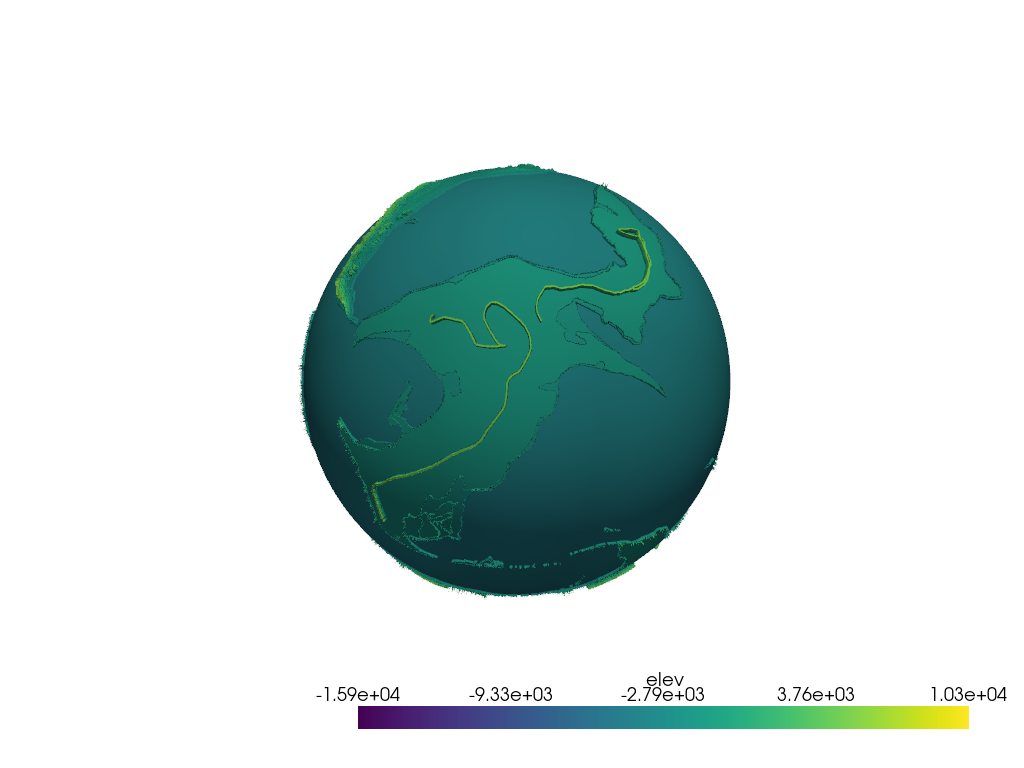

In [18]:
#Displays mesh data on an interactable globe
#If you don't see one, make sure the script is "Trusted" in the upper right and/or reload the page 
npzelev = os.path.join(input_path, str(st_time) + "Ma")
paleovtk = npzelev + ".vtk"

# Define mesh
if len(uplift_map) < 1 and len(precip_map) < 1:
    vis_mesh = meshio.Mesh(coords, {"triangle": cells}, 
                       point_data={"elev": elev})
elif len(uplift_map) < 1:
    vis_mesh = meshio.Mesh(coords, {"triangle": cells}, 
                       point_data={"elev": elev, "precip": meshd})
elif len(precip_map) < 1:
    vis_mesh = meshio.Mesh(coords, {"triangle": cells}, 
                       point_data={"elev": elev, "uplift": meshu})
else:
    vis_mesh = meshio.Mesh(coords, {"triangle": cells}, 
                       point_data={"elev": elev, "precip": meshd, "uplift": meshu})

# Write it to disk
meshio.write(paleovtk, vis_mesh)

print("Writing VTK input file as {}".format(paleovtk))

mesh = pv.read(paleovtk)
melev = mesh.get_array(name='elev')

planRadius = planrad*1000
scale = 20.
factor = 1.+ (melev/planRadius)*scale

mesh.points[:, 0] *= factor
mesh.points[:, 1] *= factor
mesh.points[:, 2] *= factor

contour = mesh.contour([0])

plotter = pv.Plotter()
plotter.add_mesh(mesh, scalars="elev")
plotter.add_mesh(contour, color="black", opacity=1.)
plotter.show(jupyter_backend='static')

In [ ]:
# Runs model; can take hours but it'll report its progress as it runs

#multi-core; replace number with your available cpu cores
!mpirun -np 2 --allow-run-as-root python3 runModel.py -i inputs/input.yml

#single-core
# %run script/runModel.py -i inputs/input.yml

In [ ]:
#Displays output on interactable globe

stp = 5
uplift_forcing = False

# Reading the final output generated by gospl
output = mout.mapOutputs(path='./inputs', filename='input.yml',step=stp, uplift=False)
output.exportVTK(f'step{stp}.vtk')

mesh = pv.read(f'step{stp}.vtk')
elev = mesh.get_array(name='elev')

planRadius = planrad*1000
scale = 20.
factor = 1.+ (elev/planRadius)*scale

mesh.points[:, 0] *= factor
mesh.points[:, 1] *= factor
mesh.points[:, 2] *= factor

contour = mesh.contour([0])

plot = pv.Plotter()
plot.add_mesh(mesh, scalars="elev")
plot.add_mesh(contour, color="black", opacity=1.)
plot.show(jupyter_backend='static')

In [ ]:
#Saves output to netcdf file
import mapOutputs as mout

stp = 5
reso = 0.06

grid = mout.mapOutputs(path='./inputs', filename='input.yml',step=stp, uplift=False)
grid.getData(stp)
grid.buildLonLatMesh(res=reso, nghb=3)
grid.exportNetCDF(ncfile = 'out.nc')


In [ ]:
#Trimmed Version; saves only elevation, in 4 quadrants
import mapOutputs as mout

stp = 5
reso = 0.02

grid = mout.mapOutputs(path='./inputs', filename='input.yml',step=stp, uplift=False)
grid.getData_e(stp)
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [-180.0,0.0,0.0,90.0])
grid.exportNetCDF_e(ncfile = 'outnw.nc')
grid = mout.mapOutputs(path='./inputs', filename='input.yml',step=stp, uplift=False)
grid.getData_e(stp)
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [0.0,0.0,180.0,90.0])
grid.exportNetCDF_e(ncfile = 'outne.nc')
grid = mout.mapOutputs(path='./inputs', filename='input.yml',step=stp, uplift=False)
grid.getData_e(stp)
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [-180.0,-90.0,0.0,0.0])
grid.exportNetCDF_e(ncfile = 'outsw.nc')
grid = mout.mapOutputs(path='./inputs', filename='input.yml',step=stp, uplift=False)
grid.getData_e(stp)
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [0.0,-90.0,180.0,0.0])
grid.exportNetCDF_e(ncfile = 'outse.nc')


In [ ]:
#saves only elevation, in 16 pieces
import mapOutputs as mout

stp = 3
reso = 0.02

grid = mout.mapOutputs(path='./inputs', filename='input.yml',step=stp, uplift=False)
grid.getData_e(stp)
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [-180.0,45.0,-90.0,90.0])
grid.exportNetCDF_e(ncfile = 'outnnww.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [-90.0,45.0,0.0,90.0])
grid.exportNetCDF_e(ncfile = 'outnnw.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [0.0,45.0,90.0,90.0])
grid.exportNetCDF_e(ncfile = 'outnne.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [90.0,45.0,180.0,90.0])
grid.exportNetCDF_e(ncfile = 'outnnee.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [-180.0,0.0,-90.0,45.0])
grid.exportNetCDF_e(ncfile = 'outnww.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [-90.0,0.0,0.0,45.0])
grid.exportNetCDF_e(ncfile = 'outnw.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [0.0,0.0,90.0,45.0])
grid.exportNetCDF_e(ncfile = 'outne.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [90.0,0.0,180.0,45.0])
grid.exportNetCDF_e(ncfile = 'outnee.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [-180.0,-45.0,-90.0,0.0])
grid.exportNetCDF_e(ncfile = 'outsww.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [-90.0,-45.0,0.0,0.0])
grid.exportNetCDF_e(ncfile = 'outsw.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [0.0,-45.0,90.0,0.0])
grid.exportNetCDF_e(ncfile = 'outse.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [90.0,-45.0,180.0,0.0])
grid.exportNetCDF_e(ncfile = 'outsee.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [-180.0,-90.0,-90.0,-45.0])
grid.exportNetCDF_e(ncfile = 'outssww.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [-90.0,-90.0,0.0,-45.0])
grid.exportNetCDF_e(ncfile = 'outssw.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [0.0,-90.0,90.0,-45.0])
grid.exportNetCDF_e(ncfile = 'outsse.nc')
grid.buildLonLatMesh_e(res=reso, nghb=3, box = [90.0,-90.0,180.0,-45.0])
grid.exportNetCDF_e(ncfile = 'outssee.nc')